In [1]:
# importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError
from math import sqrt, ceil, floor

In [2]:
# Leer train y test
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [3]:
train['idSecuencia'] = pd.to_datetime(train['idSecuencia'])
test['idSecuencia'] = pd.to_datetime(test['idSecuencia'])

In [4]:
# create a dataframe with the mean of udsVenta for each idSku where bolHoliday = 1 in one column and bolHoliday = 0 in another column
train_mean = train.groupby(['idSku', 'bolHoliday'])['udsVenta'].mean().reset_index()
train_mean = train_mean.pivot(index='idSku', columns='bolHoliday', values='udsVenta').reset_index()
train_mean.columns = ['idSku', 'mean_no_holiday', 'mean_holiday']
train_mean.fillna(0, inplace=True)

train_mean['mean_holiday'] = train_mean['mean_holiday'].apply(lambda x: round(x))
train_mean['mean_no_holiday'] = train_mean['mean_no_holiday'].apply(lambda x: floor(x))

train_mean

,idSku,mean_no_holiday,mean_holiday
0,1,16,0
1,2,20,1
2,3,11,1
3,4,10,1
4,5,13,0
5,6,12,0
6,7,11,0
7,8,6,0
8,9,7,0
9,10,7,1


In [5]:
test = test[['idSku', 'idSecuencia', 'bolHoliday', 'udsVenta']]
test = pd.merge(test, train_mean, on='idSku', how='left')
test['udsVenta_pred'] = np.where(test['bolHoliday'] == 1, test['mean_holiday'], test['mean_no_holiday'])
test.drop(['mean_holiday', 'mean_no_holiday'], axis=1, inplace=True)
test.head()

,idSku,idSecuencia,bolHoliday,udsVenta,udsVenta_pred
0,1,2021-11-07,1,0,0
1,1,2021-11-08,0,27,16
2,1,2021-11-09,0,9,16
3,1,2021-11-10,0,0,16
4,1,2021-11-11,0,9,16


In [6]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime
0,1,18,2
1,2,28,4
2,3,28,2
3,4,14,2
4,5,14,4


In [7]:
# create a column named ciclo_aprovisionamiento with sum of diasEntrePedidos and diasLeadtime
df_ciclo['ciclo_aprovisionamiento'] = df_ciclo['diasEntrePedidos'] + df_ciclo['diasLeadtime']
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento
0,1,18,2,20
1,2,28,4,32
2,3,28,2,30
3,4,14,2,16
4,5,14,4,18


In [8]:
results = pd.DataFrame(columns=['idSku', 'target', 'prediction'])
# iterate over each sku of df_ciclo
for i in range(len(df_ciclo)):

    # get the sku
    sku = df_ciclo.loc[i, 'idSku']

    # get the ciclo_aprovisionamiento
    ciclo_aprovisionamiento = df_ciclo.loc[i, 'ciclo_aprovisionamiento']

    # create a dataframe with the idSku = sku
    df_sku = test[test['idSku'] == sku]
    # create a column with the sum of udsVenta_pred for de last ciclo_aprovisionamiento days
    df_sku['udsVenta_pred_sum'] = df_sku['udsVenta_pred'].rolling(ciclo_aprovisionamiento).sum()
    df_sku['udsVenta_sum'] = df_sku['udsVenta'].rolling(ciclo_aprovisionamiento).sum()
    df_sku.dropna(inplace=True)
    target = df_sku['udsVenta_pred_sum']
    prediction = df_sku['udsVenta_sum']
    results = results.append({'idSku': i+1, 'target': target, 'prediction': prediction}, ignore_index=True)

C:\Users\96gar\AppData\Local\Temp\ipykernel_9232\1905802996.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['udsVenta_pred_sum'] = df_sku['udsVenta_pred'].rolling(ciclo_aprovisionamiento).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_9232\1905802996.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['udsVenta_sum'] = df_sku['udsVenta'].rolling(ciclo_aprovisionamiento).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_9232\1905802996.py:16: SettingWithCopyWarning: 
A value is trying 

In [9]:
# RMSE: Root Mean Squared Error
# MAPE: Mean Absolute Percentage Error
# MASE: Mean Absolute Scaled Error
# SMAPE: Symmetric Mean Absolute Percentage Error
# RMSSE: Root Mean Squared Scaled Error

results['RMSE'] = np.nan
results['MAPE'] = np.nan
results['MASE'] = np.nan
results['SMAPE'] = np.nan
results['RMSSE'] = np.nan

rmse = MeanSquaredError(square_root=True)
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
smape = MeanAbsolutePercentageError(symmetric=True)
rmsse = MeanSquaredScaledError(square_root=True)

# calculate rmse for each sku and append to results dataframe
for i in range(0, 50):
    t = results['target'][i]
    p = results['prediction'][i]
    y_train = train[train['idSku'] == i+1]['udsVenta']
    results['RMSE'][i] = rmse(t, p)
    results['MAPE'][i] = mape(t, p)
    results['MASE'][i] = mase(t, p, y_train=y_train)
    results['SMAPE'][i] = smape(t, p)
    results['RMSSE'][i] = rmsse(t, p, y_train=y_train)
results

C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_9232\3209599410.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['RMSE'][i] = rmse(t, p)
C:\Users\96gar\AppData\Roaming\Python\Python38\site-packages\sktime\performance_metrics\forecasting\_classes.py:422: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
C:\Users\96gar\AppData\Local\Temp\ipykernel_9232\3209599410.py:25: SettingWithCopyWa

,idSku,target,prediction,RMSE,MAPE,MASE,SMAPE,RMSSE
0,1,19 272.0 20 288.0 21 272.0 22 ...,19 264.0 20 276.0 21 249.0 22 ...,51.031111,0.176759,4.009136,0.159724,3.532625
1,2,159 507.0 160 526.0 161 526.0 162 ...,159 486.0 160 495.0 161 486.0 162 ...,63.169629,0.092046,3.559300,0.100153,3.662586
2,3,285 270.0 286 280.0 287 270.0 288 ...,285 246.0 286 264.0 287 255.0 288 ...,25.151059,0.064403,2.013829,0.068845,2.199608
3,4,399 133.0 400 142.0 401 142.0 402 ...,399 105.0 400 114.0 401 123.0 402 ...,24.294651,0.156671,2.578052,0.173096,2.347099
4,5,529 195.0 530 208.0 531 208.0 532 ...,529 33.0 530 42.0 531 42.0 532 ...,49.658927,0.181639,3.698118,0.205600,3.926197
5,6,652 132.0 653 144.0 654 132.0 655 ...,652 69.0 653 84.0 654 75.0 655 ...,39.972620,0.287448,3.837798,0.300039,3.241851
6,7,797 264.0 798 275.0 799 264.0 800 ...,797 183.0 798 195.0 799 189.0 800 ...,57.081459,0.195240,7.272538,0.221375,6.257421
7,8,907 60.0 908 66.0 909 66.0 910 ...,907 62.0 908 77.0 909 79.0 910 ...,32.521788,0.457760,4.384362,0.362597,4.277003
8,9,1032 42.0 1033 49.0 1034 49.0 1035 ...,1032 96.0 1033 108.0 1034 114.0 1035...,60.754012,1.154386,10.107426,0.714594,7.783402
9,10,1162 65.0 1163 71.0 1164 71.0 1165 ...,1162 82.0 1163 91.0 1164 90.0 1165 ...,21.532199,0.287055,3.343247,0.341446,2.995519


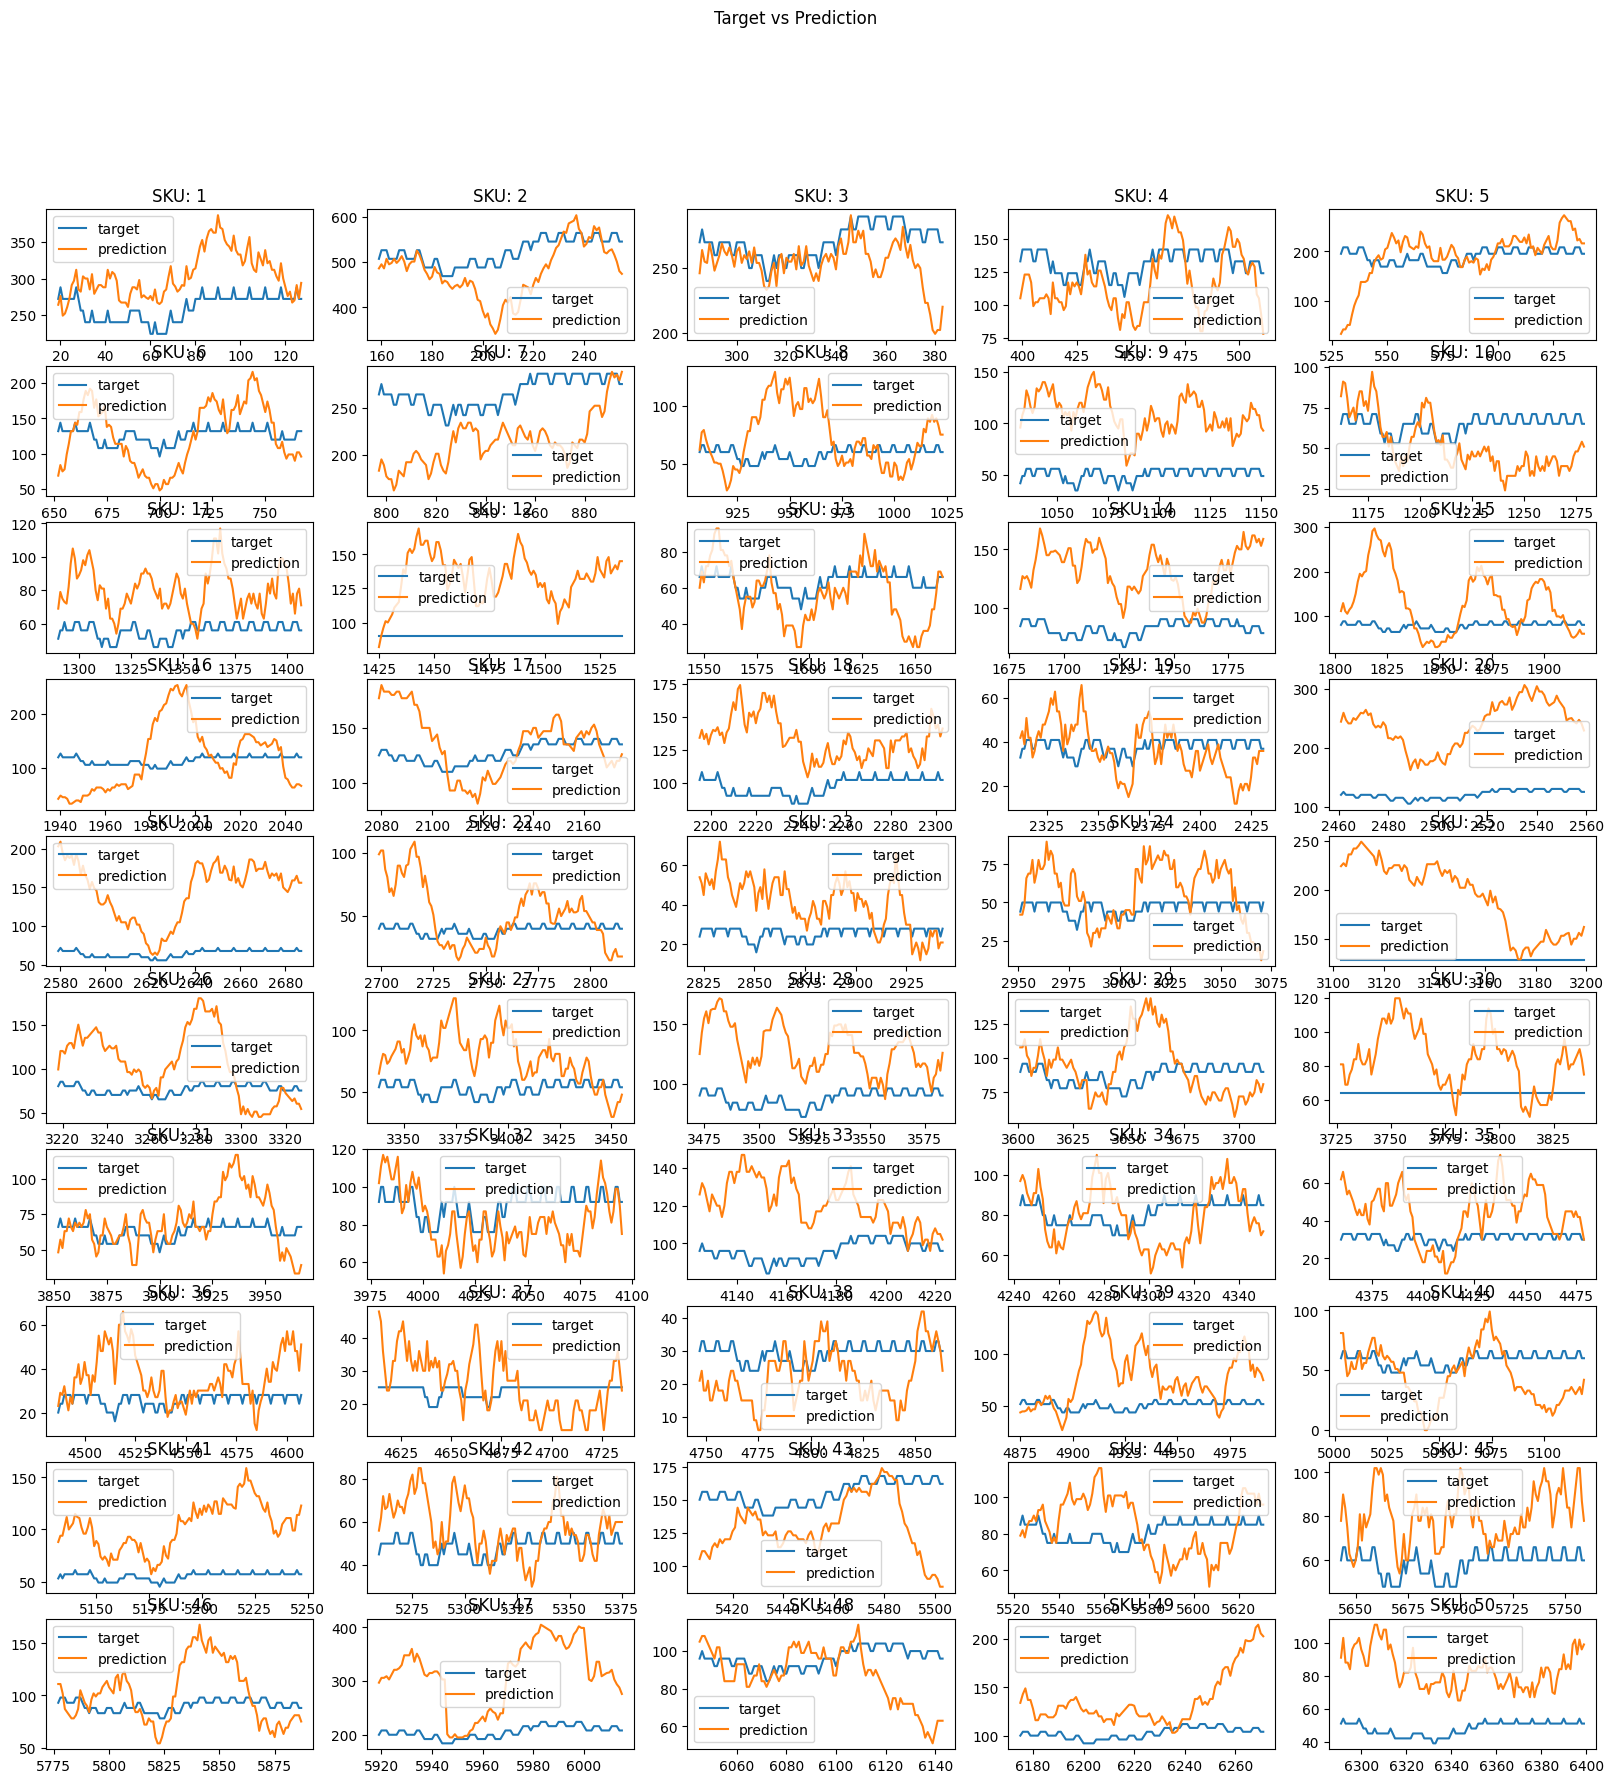

In [10]:
# make 50 subplots in a 10x5 grid and plot the target and prediction
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
fig.suptitle('Target vs Prediction')
for i in range(10):
    for j in range(5):
        axs[i, j].plot(results['target'][i*5+j], label='target')
        axs[i, j].plot(results['prediction'][i*5+j], label='prediction')
        axs[i, j].legend()
        axs[i, j].set_title('SKU: ' + str(i*5+j+1))
plt.show()

In [11]:
# get the metrics of the results dataframe
metrics = results[['RMSE', 'MAPE', 'MASE', 'SMAPE', 'RMSSE']]

# get the mean of each metric
metrics_mean = metrics.mean()
metrics_mean

RMSE     38.319767
MAPE      0.411974
MASE      5.909763
SMAPE     0.335137
RMSSE     5.150084
dtype: float64

In [12]:
df_precio = pd.read_excel('../Data/DatosPrecioMedio.xlsx')
df_precio = df_precio.rename(columns={'idSkuIta': 'idSku'})
df_precio = df_precio.sort_values(by=['idSku']).reset_index(drop=True)
df_precio.head()

,idSku,eurPrecioMedio
0,1,1.370002
1,2,1.370002
2,3,1.370002
3,4,1.370002
4,5,1.370002


In [13]:
df_ciclo = df_ciclo.merge(df_precio, on='idSku', how='inner')
df_ciclo = df_ciclo.merge(results[['idSku', 'RMSE']], on='idSku', how='inner')
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE
0,1,18,2,20,1.370002,51.031111
1,2,28,4,32,1.370002,63.169629
2,3,28,2,30,1.370002,25.151059
3,4,14,2,16,1.370002,24.294651
4,5,14,4,18,1.370002,49.658927


Stock de seguridad = Factor servicio *RMSE * raíz del ciclo de aprovisionamiento

In [14]:
factor = 1.64
df_ciclo['stock_seguridad'] = df_ciclo.apply(lambda x: ceil(factor * x['RMSE'] * sqrt(x['ciclo_aprovisionamiento'])), axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad
0,1,18,2,20,1.370002,51.031111,375
1,2,28,4,32,1.370002,63.169629,587
2,3,28,2,30,1.370002,25.151059,226
3,4,14,2,16,1.370002,24.294651,160
4,5,14,4,18,1.370002,49.658927,346


In [15]:
df_ciclo['coste_stock_diario'] = df_ciclo.apply(lambda x: 0.05 * x['eurPrecioMedio'] * x['stock_seguridad'], axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad,coste_stock_diario
0,1,18,2,20,1.370002,51.031111,375,25.687529
1,2,28,4,32,1.370002,63.169629,587,40.209546
2,3,28,2,30,1.370002,25.151059,226,15.481018
3,4,14,2,16,1.370002,24.294651,160,10.960013
4,5,14,4,18,1.370002,49.658927,346,23.701027


In [16]:
coste_stock_diario_total = df_ciclo['coste_stock_diario'].sum().round(2)
coste_stock_diario_anual = coste_stock_diario_total * 365

print('Coste stock total diario: {}€'.format(coste_stock_diario_total))
print('Coste stock total anual: {}€'.format(coste_stock_diario_anual))

Coste stock total diario: 2169.9€
Coste stock total anual: 792013.5€
